# Capstone Project

## Problem Statement

The H hotel's business development department wants to list the hotel on the TripAdvisor website.  The survey result shows  96% of TripAdvisor users consider review rating necessary when planning trips and booking hotels. With online reviews rating having such a strong influence on consumers, the Business Development team tasked us to develop a model to predict possible H hotel review rating on TripAdvisor after the listing based on their current customers' feedback. It will reinforce the value of successful online reputation management for hotels and the resulting positive impact on revenue.

In this project, I will use Multinomial Naive Bay as a baseline model to predict the overall rating. Further, I will use other advance models/techniques like Neural network, deep learning to see if there is any improvement. The accuracy score will guide the model's performance. Ultimately, I will conclude the best model based on accuracy score. 

Challenges

From EDA, firstly, we can see that it contains the unbalanced classes of rating for all rating aspects. If we train a classification model without fixing this problem, the model will be completely biased. It also impacts the correlations between features. Techniques should be acquired to balance the dataset. 
Secondly, extensive data set has high dimension text features(325740 features), which means the data consists of a large number of noise that can not be directly used for modeling. I have to find the right approach for the dimension reduction.
Lastly, It seems more challenging for predicting aspects rating. I will give a try. It mostly likely to be involved in the further study.  

In [3]:
import json,os
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os import path
from PIL import Image
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.utils import resample
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV

## 1. File loading

TripAdvisor dataset download from the [website](http://times.cs.uiuc.edu/~wang296/Data/). It contains 12,773 JSON files; each JSON file contains the reviews and the ratings from different aspects. I loaded the JSON file and converted it to the CSV file. I will not run the code for the loading and converting process as it took hours to complete.

In [2]:
#directory_path = "./json/"
#json_files = [pos_json for pos_json in os.listdir(directory_path) if pos_json.endswith('.json')]
#file=[]
#for ind in range(12773):
    #with open(directory_path+json_files[ind]) as f:
             #file.append(json.load(f))
#tripadvisor = pd.DataFrame()
#for ind in range(len(file)):
      #tripadvisor.append(pd.json_normalize (file[ind]["Reviews"]))

#tripadvisor.to_csv('./tripadvisor.csv')

In [4]:
#load the CSV file in case not scraping
df = pd.read_csv('./tripadvisor.csv')

## 2. Data Cleaning

In [10]:
#check the datafram 
df.shape

(1621956, 3)

In [11]:
#display first 5 rows
df.head()

,Ratings,Title,Content
0,"{'Service': '5', 'Cleanliness': '5', 'Overall'...",“Great place and location”,"Usually stay near the airport, but this trip w..."
1,"{'Service': '4', 'Cleanliness': '4', 'Overall'...","“Nice stay, nice surroundings”",Stayed at this Hilton for 2 nights. It was lik...
2,"{'Service': '5', 'Cleanliness': '5', 'Overall'...",“Perfect for an overnight just off I-95”,"Stayed there one night, December 16, on the wa..."
3,"{'Service': '5', 'Cleanliness': '5', 'Overall'...",“Great Hotel”,I just stayed here last weekend and have alrea...
4,"{'Service': '5', 'Cleanliness': '5', 'Overall'...",“good room for handicapped person”,My mother who is 90 and I stayed one night on ...


In [7]:
#drop the unnecessary rows
df=df.drop(columns=["Unnamed: 0","AuthorLocation","Author","Date","ReviewID"],inplace=False)

In [9]:
#convert the column "Rating" to dataframe
rating=[]
for item in df['Ratings'].values.tolist():
          rating.append(ast.literal_eval(item))
df2 = pd.DataFrame(rating)

In [12]:
#merge the dateframe with the original dateframe by index
df=pd.concat([df, df2], axis=1).reindex(df.index)

In [13]:
#drop the "ratings" column
df=df.drop(columns=["Ratings"])

In [14]:
#creat a column combine "Title" and "Content"
df["feature"] = df["Title"] + " " + df["Content"]

In [15]:
#check the duplicated rows
df.duplicated().value_counts()

False    1178978
True      442978
dtype: int64

In [16]:
#drop teh duplicate rows in dataframe
df=df.drop_duplicates()

In [17]:
#convert the column "feature" to str
df['feature'] = df['feature'].astype('str') 

In [18]:
df.isnull().sum()

Title                                        145112
Content                                           0
Service                                       92119
Cleanliness                                   93822
Overall                                           0
Value                                         92412
Sleep Quality                                635069
Rooms                                        182349
Location                                     230504
Business service (e.g., internet access)    1069297
Check in / front desk                        855563
Business service                            1033866
feature                                           0
dtype: int64

In [19]:
#fill Nan value with O as Machine learning need the number input in modeling part
df.fillna(0, inplace = True)

In [20]:
#drop the unnecessary rows
df=df.drop(columns=["Title","Content"])

In [21]:
#check the data type in dataframe
df.dtypes

Service                                     object
Cleanliness                                 object
Overall                                     object
Value                                       object
Sleep Quality                               object
Rooms                                       object
Location                                    object
Business service (e.g., internet access)    object
Check in / front desk                       object
Business service                            object
feature                                     object
dtype: object

In [23]:
#change the data type
df[["Service","Cleanliness","Overall","Value","Sleep Quality","Rooms","Location","Business service (e.g., internet access)",\
    "Check in / front desk","Business service"]]=df[["Service","Cleanliness","Overall","Value","Sleep Quality","Rooms",\
                                                     "Location","Business service (e.g., internet access)",\
                                                     "Check in / front desk","Business service"]].astype('float')

In [24]:
#change the data type
df["feature"]= df["feature"].astype('str')

In [26]:
#rename the columns
df=df.rename(columns={"Service": "service", "Cleanliness": "cleanliness","Overall":"overall","Value":"value",\
                   "Sleep Quality":"sleep_quality","Rooms":"room","Location":"location",\
                  "Business service (e.g., internet access)":"internet_service","Check in / front desk":"front_desk",\
                     "Business service":"business_service"})

In [27]:
#check the statistic information
df.describe()

,service,cleanliness,overall,value,sleep_quality,room,location,internet_service,front_desk,business_service
count,1.178978e+06,1.178978e+06,1.178978e+06,1.178978e+06,1.178978e+06,1.178978e+06,1.178978e+06,1.178978e+06,1.178978e+06,1.178978e+06
mean,3.568174e+00,3.719172e+00,3.924541e+00,3.416410e+00,1.881992e+00,3.159192e+00,3.171195e+00,3.340427e-01,7.920971e-01,8.126275e-02
std,1.764858e+00,1.751856e+00,1.212681e+00,1.777834e+00,2.179958e+00,1.902424e+00,2.164972e+00,1.111197e+00,1.769487e+00,8.585213e-01
min,-1.000000e+00,-1.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00
25%,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,0.000000e+00,4.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,4.000000e+00,5.000000e+00,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00


There is the outlier -1 in the dataset. -1 is an impossible value for the Tripadvisor rating system. I also realize that there is no rating 1 existing in the dataset. I think it is an error when collecting or converting the data. -1 should be 1. Thus, I replace all -1 with value 1

In [28]:
#drop the outliers
df=df.replace(-1, 1)

In [29]:
#check the data again
df.describe()

,service,cleanliness,overall,value,sleep_quality,room,location,internet_service,front_desk,business_service
count,1.178978e+06,1.178978e+06,1.178978e+06,1.178978e+06,1.178978e+06,1.178978e+06,1.178978e+06,1.178978e+06,1.178978e+06,1.178978e+06
mean,3.626773e+00,3.780807e+00,3.924541e+00,3.491490e+00,1.881992e+00,3.214884e+00,3.290890e+00,3.340427e-01,9.117515e-01,2.411266e-01
std,1.641070e+00,1.614540e+00,1.212681e+00,1.625438e+00,2.179958e+00,1.806718e+00,1.978288e+00,1.111197e+00,1.710910e+00,8.279616e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,0.000000e+00,2.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,0.000000e+00,4.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,4.000000e+00,5.000000e+00,5.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
max,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00


In [30]:
#check the data shape again
df.shape

(1178978, 11)

In [31]:
df.head()

,service,cleanliness,overall,value,sleep_quality,room,location,internet_service,front_desk,business_service,feature
0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,0.0,0.0,0.0,“Great place and location” Usually stay near t...
1,4.0,4.0,4.0,4.0,4.0,4.0,5.0,0.0,0.0,0.0,"“Nice stay, nice surroundings” Stayed at this ..."
2,5.0,5.0,4.0,3.0,3.0,5.0,5.0,0.0,0.0,0.0,“Perfect for an overnight just off I-95” Staye...
3,5.0,5.0,5.0,4.0,5.0,5.0,5.0,0.0,0.0,0.0,“Great Hotel” I just stayed here last weekend ...
4,5.0,5.0,5.0,4.0,5.0,5.0,5.0,0.0,0.0,0.0,“good room for handicapped person” My mother w...


In [32]:
df.to_csv('./tripadvisor_clean.csv')

#### Data Dictionary

|Features                    | Type    |Description
|:---------------------------|:--------|:----------------------------------------------------------------------------------------
| feature                    | string  |customer review combine review title and content
| service                    | float   |rating 1 to 5 , 0: no rating for this aspect
| cleanliness                | float   |rating 1 to 5 , 0: no rating for this aspect
| overall                    | float   |rating 1 to 5 , 0: no rating for this aspect
| value                      | float   |rating 1 to 5 , 0: no rating for this aspect
| sleep_quality	             | float   |rating 1 to 5 , 0: no rating for this aspect
| room                       | float   |rating 1 to 5 , 0: no rating for this aspect
| location                   | float   |rating 1 to 5 , 0: no rating for this aspect
| internet_service           | float   |rating 1 to 5 , 0: no rating for this aspect
| business_service           | float   |rating 1 to 5 , 0: no rating for this aspect           
| front_desk                 | float   |rating 1 to 5 , 0: no rating for this aspect

## 3. EDA

In [33]:
df = pd.read_csv('./tripadvisor_clean.csv')

In [35]:
df.head()

,Unnamed: 0,service,cleanliness,overall,value,sleep_quality,room,location,internet_service,front_desk,business_service,feature
0,0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,0.0,0.0,0.0,“Great place and location” Usually stay near t...
1,1,4.0,4.0,4.0,4.0,4.0,4.0,5.0,0.0,0.0,0.0,"“Nice stay, nice surroundings” Stayed at this ..."
2,2,5.0,5.0,4.0,3.0,3.0,5.0,5.0,0.0,0.0,0.0,“Perfect for an overnight just off I-95” Staye...
3,3,5.0,5.0,5.0,4.0,5.0,5.0,5.0,0.0,0.0,0.0,“Great Hotel” I just stayed here last weekend ...
4,4,5.0,5.0,5.0,4.0,5.0,5.0,5.0,0.0,0.0,0.0,“good room for handicapped person” My mother w...


In [36]:
#drop Unnamed
df=df.drop(columns=["Unnamed: 0"])

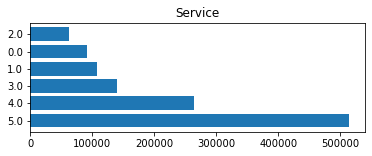

In [37]:
#plot the distribution plot for Target variable
ax=df.service.value_counts().plot(kind="barh",figsize=(6,2),title="Service",width=0.8)
ax.set_facecolor('white')

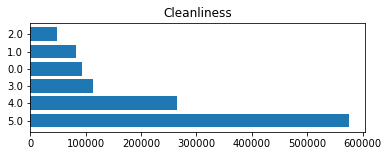

In [38]:
#plot the distribution plot for Target variable
ax=df.cleanliness.value_counts().plot(kind="barh",figsize=(6,2),title="Cleanliness",width=0.8)
ax.set_facecolor('white')

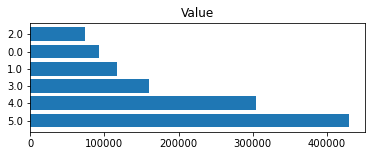

In [39]:
#plot the distribution plot for Target variable
ax=df.value.value_counts().plot(kind="barh",figsize=(6,2),title="Value",width=0.8)
ax.set_facecolor('white')

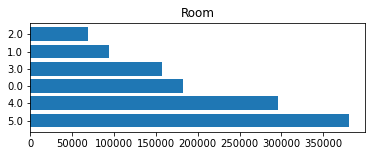

In [40]:
#plot the distribution plot for Target variable
ax=df.room.value_counts().plot(kind="barh",figsize=(6,2),title="Room",width=0.8)
ax.set_facecolor('white')

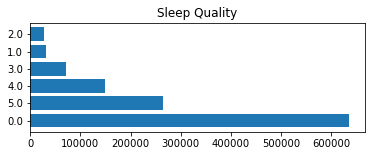

In [41]:
#plot the distribution plot for Target variable
ax=df.sleep_quality.value_counts().plot(kind="barh",figsize=(6,2),title="Sleep Quality",width=0.8)
ax.set_facecolor('white')

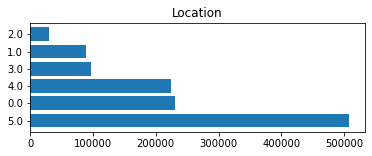

In [42]:
#plot the distribution plot for Target variable
ax=df.location.value_counts().plot(kind="barh",figsize=(6,2),title="Location",width=0.8)
ax.set_facecolor('white')

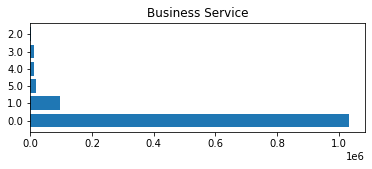

In [43]:
#plot the distribution plot for Target variable
ax=df.business_service.value_counts().plot(kind="barh",figsize=(6,2),title="Business Service",width=0.8)
ax.set_facecolor('white')

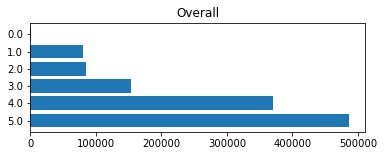

In [44]:
#plot the distribution plot for Target variable
ax=df.overall.value_counts().plot(kind="barh",figsize=(6,2),title="Overall",width=0.8)
ax.set_facecolor('white')

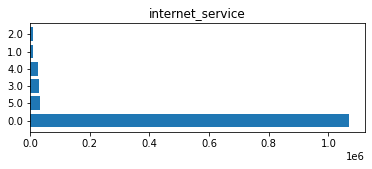

In [47]:
#plot the distribution plot for Target variable
ax=df.internet_service.value_counts().plot(kind="barh",figsize=(6,2),title="internet_service",width=0.8)
ax.set_facecolor('white')

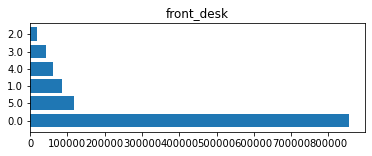

In [48]:
#plot the distribution plot for Target variable
ax=df.front_desk.value_counts().plot(kind="barh",figsize=(6,2),title="front_desk",width=0.8)
ax.set_facecolor('white')

It contains the unbalanced classes of rating for all rating aspects

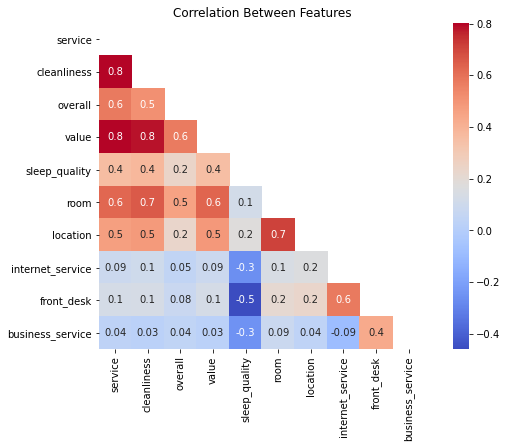

In [49]:
# Investigate for features that are highly correlated to one another.

plt.figure(figsize = (10,6))
plt.title('Correlation Between Features', size=12)
matrix = np.triu(df.corr())
sns.heatmap(df.corr(), annot=True, fmt='.1g', mask=matrix, cmap= 'coolwarm', square=True);

#### Balance the class by downsize the majority group. As there is total 490 million Tripadvisor users,  we will assume the sample rating mean for Tripadviosr users will be normally distributed. According to the [sample size statistic calculation](https://www.surveysystem.com/sscalc.htm), we only need thousand of sample to achieve Confidence Level:95% and confidence interval:3% to represent the whole population's choices. Hence we will downsize the Majority group because we have enough data points. 

#### Also, from the Heatmap , we can see some aspects rating are high correlated to overall rating, some aspects are not. It is neccesory to identify the groups of words (called a topic) from a collection of documents that contains best information in the collection in order to have a better predict for the overall rating.

In [21]:
df_majority = df[df.overall==5]
df_minority = df[df.overall==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=80794,     # to match minority class
                                 random_state=123) # reproducible results
df_3 = resample(df[df.overall==3], 
                                 replace=False,    # sample without replacement
                                 n_samples=80794,     # to match minority class
                                 random_state=123) # reproducible results
df_4 = resample(df[df.overall==4], 
                                 replace=False,    # sample without replacement
                                 n_samples=80794,     # to match minority class
                                 random_state=123) # reproducible results
df_2 = resample(df[df.overall==2], 
                                 replace=False,    # sample without replacement
                                 n_samples=80794,     # to match minority class
                                 random_state=123) # reproducible results
  
 
# Combine minority class with downsampled majority class
overall = pd.concat([df_majority_downsampled, df_minority])
overall = pd.concat([overall, df_3])
overall = pd.concat([overall, df_4])
overall = pd.concat([overall, df_2])
overall["overall"].value_counts()

3.0    80794
5.0    80794
4.0    80794
2.0    80794
1.0    80794
Name: overall, dtype: int64

In [22]:
#change the data type
overall["feature"]= overall["feature"].astype('str')

In [23]:
overall=overall.drop(columns=["service","room","cleanliness","location","business_service","sleep_quality","value",\
                      "Check in / front desk","Business service"])

In [24]:
overall.shape

(403970, 2)

#### Train/Test Split

In [25]:
# Create train_test_split.
X_train, X_test, y_train, y_test = train_test_split(overall["feature"],
                                                    overall['overall'],
                                                    test_size = 0.20,
                                                    random_state = 42,)

#### Text cleaning

In [31]:
#define a funtion to clean the text feature
def clean_text(feature):
   
    #2, remove punctuations, single letters, "http", ect unneccessary words 
    letters_only = re.sub("\W", " ", feature)
    remove_single_letter = re.sub(" \w ", " ", letters_only)
    remove_single_number = re.sub(" \w ", " ", remove_single_letter)

    
     # 3. Convert to lower case, split into individual words.
    words = remove_single_number.lower().split()
    
    # 4.  convert the stop words to a set.
    stops = set(stopwords.words('english'))
    
    # 5. Remove stop words.
    meaningful_words = [w for w in words if not w in stops]
   
    # 6. return base/dictionary form of a word
    lemmatizer = WordNetLemmatizer()
    meaningful_words_lem = [lemmatizer.lemmatize(i) for i in meaningful_words]
 
    return(" ".join(meaningful_words_lem))

In [32]:
#clean the test and train set data
clean_train = []
for item in X_train:
    clean_train.append(clean_text(item))
clean_test = []
for item in X_test:
    clean_test.append(clean_text(item))

#### Baseline Model

In [33]:
#pipeline will consist of two stages
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [34]:
pipe.fit(clean_train, y_train)

Pipeline(steps=[('tvec', TfidfVectorizer()), ('nb', MultinomialNB())])

In [35]:
pipe.score(clean_train,y_train)

0.5870423546302943

In [36]:
pipe.score(clean_test,y_test)

0.5330965170680991

Extensive data set has high dimension text features(325740 features). after balanced the dataset, text features reduced to 185979. It is still a high dimension data features

In [38]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

In [39]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(clean_train)

X_train_ds = tokenizer.texts_to_sequences(clean_train)
X_test_ds = tokenizer.texts_to_sequences(clean_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train_ds = pad_sequences(X_train_ds, padding='post', maxlen=maxlen)
X_test_ds = pad_sequences(X_test_ds, padding='post', maxlen=maxlen)

In [41]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [52]:
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(embedding_layer)
dense_layer_1 = Dense(6, activation='sigmoid')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='SparseCategoricalCrossentropy', optimizer='adam', metrics=['acc'])

In [1]:
#history = model.fit(X_train_ds, y_train.values, batch_size=128, epochs=5, verbose=1, validation_split=0.2)

In [ ]:
#score = model.evaluate(X_test, y_test, verbose=1)

#print("Test Score:", score[0])
#print("Test Accuracy:", score[1]